<a href="https://colab.research.google.com/github/nadios97/hello-world/blob/master/Mewrons_KG_NMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

In [ ]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')


`labels` is a 4 by stim array of class names:  
- row 3 has the labels predicted by a deep neural network (DNN) trained on Imagenet
- rows 0-2 correspond to different levels of the wordnet hierarchy for the DNN predictions

In [ ]:
print(labels[:,:4])

[['artifact' 'entity' 'animal' 'animal']
 ['instrumentality' 'round shape' 'vertebrate' 'vertebrate']
 ['equipment' 'sphere' 'mammal' 'amphibian']
 ['croquet ball' 'bubble' 'komondor' 'tailed frog']]


In [ ]:
print(dat.keys())

dict_keys(['stimuli', 'stimuli_test', 'responses', 'responses_test', 'roi', 'roi_names'])


`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set  
- `responses`: stim x voxel array of z-scored BOLD response amplitude
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set  
- `roi`: array of voxel labels
- `roi_names`: array of names corresponding to voxel labels

In [ ]:
print(dat["stimuli"].shape)

(1750, 128, 128)


In [ ]:
print(dat["responses"].shape)

(1750, 8428)


This is the number of voxels in each ROI. Note that `"Other"` voxels have been removed from this version of the dataset:

In [ ]:
dict(zip(dat["roi_names"], np.bincount(dat["roi"])))

{'LatOcc': 928,
 'Other': 0,
 'V1': 1294,
 'V2': 2083,
 'V3': 1790,
 'V3A': 484,
 'V3B': 314,
 'V4': 1535}

Each stimulus is a 128 x 128 grayscale array:

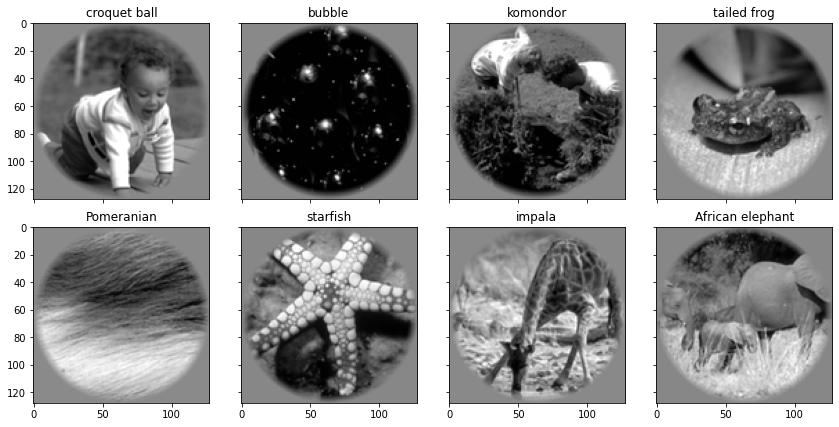

In [ ]:
f, axs = plt.subplots(2, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, dat["stimuli"], labels[-1,:]):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()

Each stimulus is associated with a pattern of BOLD response across voxels in visual cortex:

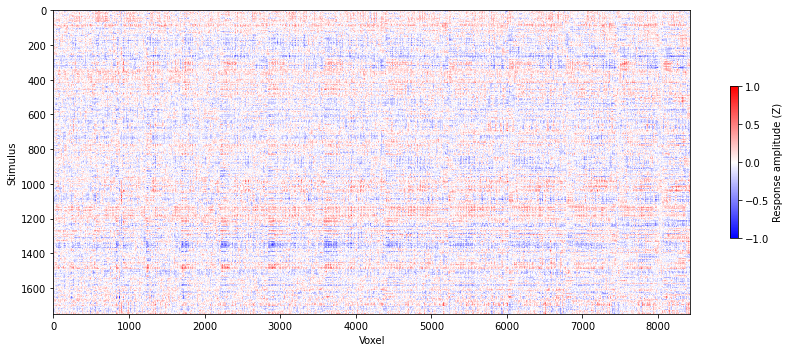

In [ ]:
f, ax = plt.subplots(figsize=(12, 5))
ax.set(xlabel="Voxel", ylabel="Stimulus")
heatmap = ax.imshow(dat["responses"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.5, label="Response amplitude (Z)")
f.tight_layout()

The training/validation splits from the original paper are retained, so the 120 test stimuli and responses are in separate data structures:

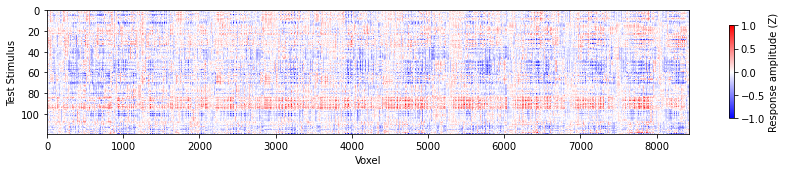

In [ ]:
f, ax = plt.subplots(figsize=(12, 2.5))
ax.set(xlabel="Voxel", ylabel="Test Stimulus")
heatmap = ax.imshow(dat["responses_test"], aspect="auto", vmin=-1, vmax=1, cmap="bwr")
f.colorbar(heatmap, shrink=.75, label="Response amplitude (Z)")
f.tight_layout()

Ridge Regression with Image Pixels

In [ ]:
from sklearn.linear_model import Ridge

train_response = dat["responses"]
test_response = dat["responses_test"]

print(train_response.shape)


train_stim = np.zeros([1750,16384])
test_stim = np.zeros([120,16384])



# Obtain flattened train data 
for i in range(0, 1750):
  train_stim[i] = dat["stimuli"][i].flatten()

# Obtain flattened test data
for i in range(0,120):
  test_stim[i] = dat["stimuli_test"][i].flatten()



#W = np.zeros([1750,8428,16384])

rr = Ridge(alpha=0.01)

W = rr.fit(train_stim, train_response) 



(1750, 8428)


In [ ]:

test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

print(np.shape(training_y_pred))
print(np.shape(training_y_true))
print(np.shape(test_y_pred))
print(np.shape(test_y_true))

(1750, 8428)
(1750, 8428)
(120, 8428)
(120, 8428)


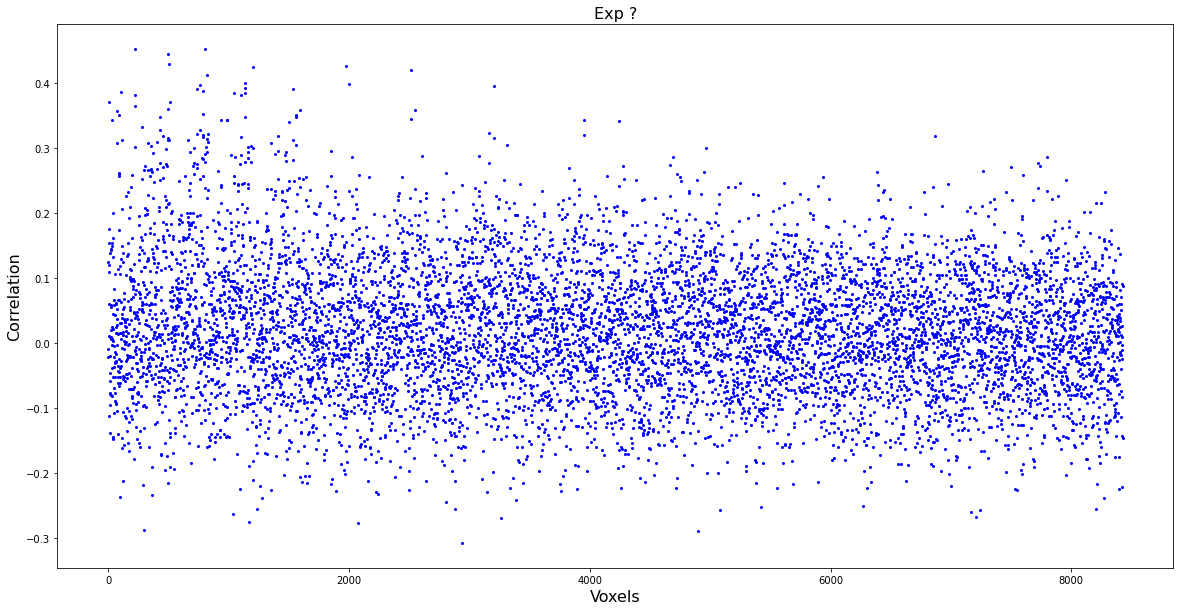

Mean of Correlation: 0.020960009781399436
Standard Deviation of Correlation:  0.1000416837303508


In [ ]:
# Finding Correlation between Predicted Response and True Response

import pandas as pd

correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(20,10))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp ?",fontsize=16)
plt.show()
print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

#correlation = np.zeros([120,120])

#for i in range(0,120):
  #test_y_pred_pd = pd.Series(test_y_pred[i])
  #for j in range(0,120):
  #  test_y_true_pd = pd.Series(test_y_true[j])
  #  correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)





0
-0.01109626032901969


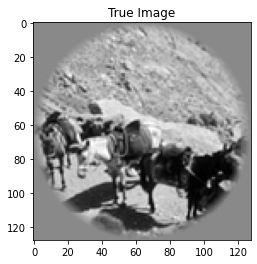

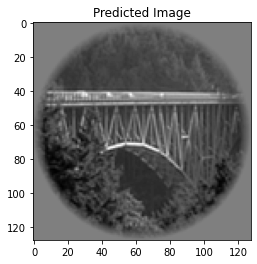

In [ ]:
pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()

In [ ]:

test_num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    test_num_of_correct = test_num_of_correct + 1
  
print("No. of correct prediction in test set: ", test_num_of_correct)


training_num_of_correct = 0
error = np.zeros(1750)
for i in range(0,1750):
  for j in range(0,1750):
    error[j] = np.linalg.norm(training_y_pred[i] - training_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    training_num_of_correct = training_num_of_correct + 1
  
print("No. of correct prediction in training set: ", training_num_of_correct)

No. of correct prediction in test set:  2


KeyboardInterrupt: ignored

Illumination Feature (Tiles of Images) +Regression

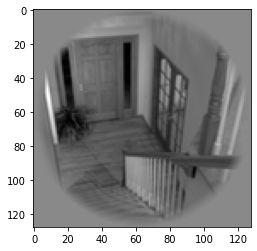

No. of correct prediction in test set:  1


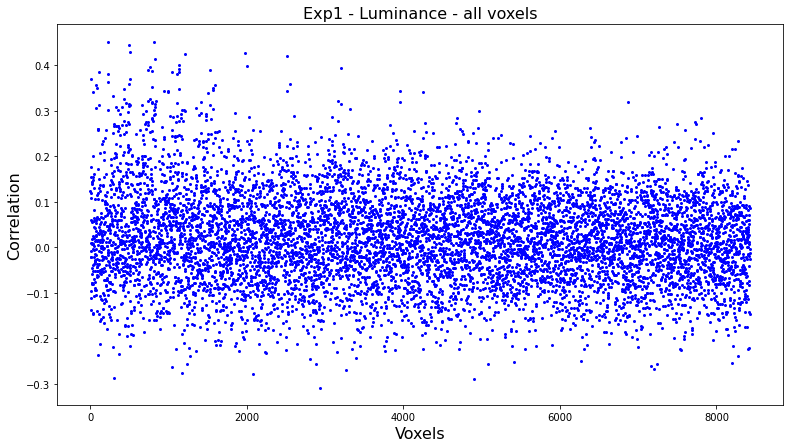

Mean of Correlation: 0.020960009781399436
Standard Deviation of Correlation:  0.1000416837303508


'\ncorrelation = np.zeros([120,120])\n\nfor i in range(0,120):\n  test_y_pred_pd = pd.Series(test_y_pred[i])\n  for j in range(0,120):\n    test_y_true_pd = pd.Series(test_y_true[j])\n    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)\n\npos = 8\nmaxpos = np.argmax(correlation[pos])\nmax = np.max(correlation[pos])\nprint(maxpos)\nprint(max)\nplt.imshow(dat["stimuli_test"][pos], cmap = "gray")\nplt.title("True Image")\nplt.show()\nplt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")\nplt.title("Predicted Image")\nplt.show()\n'

In [ ]:
def mean_of_a_tile(img, row_num, col_num, n):
  # n = number of divisions along a row or a column of an image
  total = 0
  mean = 0
  size_of_tile = int(128/n)

  for i in range(row_num, row_num + size_of_tile ):
    for j in range(col_num, col_num + size_of_tile):
      total = total + img[i][j]

  mean = total/(size_of_tile*size_of_tile)
  return mean

def image_to_tiles_feature(img, n):
  # n = number of divisions along a row or a column of an image
  feature_size = n*n
  feature = np.zeros(feature_size)
  
  row = 0
  col = 0
  size_of_tile = int(128/n)
  i = 0
  for row in range(0, 128, size_of_tile):
    for col in range(0, 128, size_of_tile):
      feature[i] = mean_of_a_tile(img, row, col, n)
      i = i + 1
      

  return feature

#feature = image_to_tiles_feature(dat["stimuli"][0], 16)
#print(feature)
#print(np.shape(feature))



train_response = dat["responses"]
test_response = dat["responses_test"]

# n = number of divisions along a row or a column of an image
n = 2
feature_size = n*n

train_stim = np.zeros([1750,feature_size])
test_stim = np.zeros([120,feature_size])

# Obtain mean illumination feature for training data
for i in range(0, 1750):
  train_stim[i] = image_to_tiles_feature(dat["stimuli"][i], n)

# Obtain mean illumination feature for test data
for i in range(0, 120):
  test_stim[i] = image_to_tiles_feature(dat["stimuli_test"][i], n)


from sklearn.linear_model import Ridge
rr = Ridge(alpha=0.01)
W = rr.fit(train_stim, train_response)

test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

#print(np.shape(training_y_pred))
#print(np.shape(training_y_true))
#print(np.shape(test_y_pred))
#print(np.shape(test_y_true))

test_num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    test_num_of_correct = test_num_of_correct + 1
    plt.imshow(dat["stimuli_test"][i],cmap="gray")
    plt.show()
  
print("No. of correct prediction in test set: ", test_num_of_correct)


import pandas as pd

correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(13,7))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp1 - Luminance - all voxels",fontsize=16)
plt.show()
print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

'''
correlation = np.zeros([120,120])

for i in range(0,120):
  test_y_pred_pd = pd.Series(test_y_pred[i])
  for j in range(0,120):
    test_y_true_pd = pd.Series(test_y_true[j])
    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)

pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()
'''

In [ ]:
'''
#breaks down image and returns the mean brightness of every tile
def image_breakdown(image, tiles):
  
  grid_means = []
  step = int(128/tiles)

  for i in range(0, 128, step):
    grid_means.append([])
    for j in range(0, 128, step):
      block = image[i:i+step,j:j+step]

      mean = np.mean(block)

      grid_means[-1].append(mean)


  grid_means= np.array(grid_means)
  return grid_means

#returns array, tiles x images
def means_per_tile(images, tiles):
  
  #initiate tile x tile matrix, tile_means
  tile_means = []
  for i in range(tiles):
    tile_means.append([])
    for j in range(tiles):
      tile_means[i].append([])



  for i in range(len(images)):
    #find mean values of tiles for image i
    grid = image_breakdown(images[i], tiles)
    
    
    #append value of each tile to corresponding position of matrix "tile_means"
    for i in range(tiles):
      for j in range(tiles):
        tile_means[i][j].append(grid[i][j])
            
  tile_means = np.array(tile_means)  
  return tile_means

images = dat['stimuli'][0]
b = means_per_tile(images, 4).flatten()

print(b.shape)
'''

'\n#breaks down image and returns the mean brightness of every tile\ndef image_breakdown(image, tiles):\n  \n  grid_means = []\n  step = int(128/tiles)\n\n  for i in range(0, 128, step):\n    grid_means.append([])\n    for j in range(0, 128, step):\n      block = image[i:i+step,j:j+step]\n\n      mean = np.mean(block)\n\n      grid_means[-1].append(mean)\n\n\n  grid_means= np.array(grid_means)\n  return grid_means\n\n#returns array, tiles x images\ndef means_per_tile(images, tiles):\n  \n  #initiate tile x tile matrix, tile_means\n  tile_means = []\n  for i in range(tiles):\n    tile_means.append([])\n    for j in range(tiles):\n      tile_means[i].append([])\n\n\n\n  for i in range(len(images)):\n    #find mean values of tiles for image i\n    grid = image_breakdown(images[i], tiles)\n    \n    \n    #append value of each tile to corresponding position of matrix "tile_means"\n    for i in range(tiles):\n      for j in range(tiles):\n        tile_means[i][j].append(grid[i][j])\n       

Ridge Regression with Canny Edge Features 

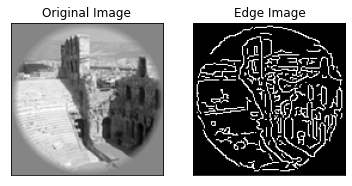

(128, 128)


In [ ]:
#Edge Detection  (Canny edge detection)

from skimage.io import imread
from skimage.feature import canny

import matplotlib.pyplot as plt

# read image
img = dat['stimuli'][10]

# find edge with Canny edge detection
edges = canny(img)

# display results
plt.subplot(121), plt.imshow(img, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(edges, cmap='gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

print(edges.shape)

No. of correct prediction in test set:  3


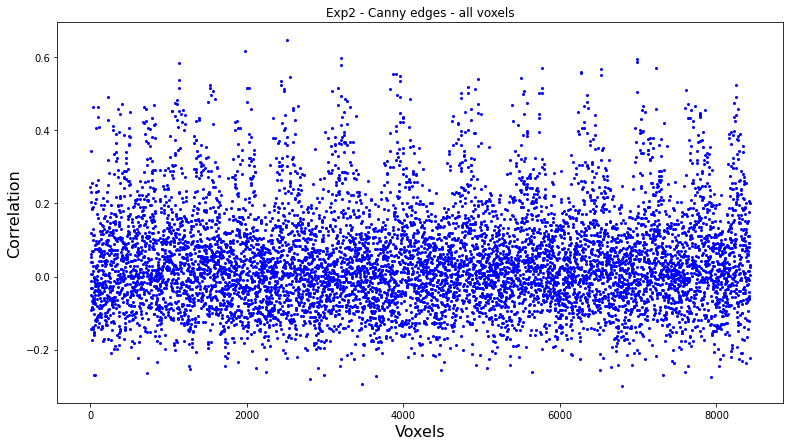

Mean of Correlation: 0.04420436429559786
Standard Deviation of Correlation:  0.1360617204652181


'\ncorrelation = np.zeros([120,120])\n\nfor i in range(0,120):\n  test_y_pred_pd = pd.Series(test_y_pred[i])\n  for j in range(0,120):\n    test_y_true_pd = pd.Series(test_y_true[j])\n    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)\n\npos = 8\nmaxpos = np.argmax(correlation[pos])\nmax = np.max(correlation[pos])\nprint(maxpos)\nprint(max)\nplt.imshow(dat["stimuli_test"][pos], cmap = "gray")\nplt.title("True Image")\nplt.show()\nplt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")\nplt.title("Predicted Image")\nplt.show()\n'

In [ ]:
from skimage.feature import canny
from sklearn.linear_model import Ridge
train_response = dat["responses"]
test_response = dat["responses_test"]


train_stim = np.zeros([1750,16384])
test_stim = np.zeros([120,16384])

for i in range(0,1750):
  # read image
  img = dat['stimuli'][i]
  # find edge with Canny edge detection
  edges = canny(img)
  train_stim[i] = edges.flatten()

for i in range(0,120):
  # read image
  img = dat['stimuli_test'][i]
  # find edge with Canny edge detection
  edges = canny(img)
  test_stim[i] = edges.flatten()

# Follow the same regression method as before

rr = Ridge(alpha=0.01)
W = rr.fit(train_stim, train_response)


test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    num_of_correct = num_of_correct + 1
  
print("No. of correct prediction in test set: ", num_of_correct)

import pandas as pd

correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(13,7))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp2 - Canny edges - all voxels")
plt.show()

print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

'''
correlation = np.zeros([120,120])

for i in range(0,120):
  test_y_pred_pd = pd.Series(test_y_pred[i])
  for j in range(0,120):
    test_y_true_pd = pd.Series(test_y_true[j])
    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)

pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()
'''

Edge Detection (Method 2) + Regression

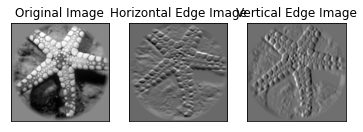

In [ ]:
import numpy as np
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v
import matplotlib.pyplot as plt


#reading the image 
image = dat['stimuli'][5]

#calculating horizontal edges using prewitt kernel
edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
edges_prewitt_vertical = prewitt_v(image)

#imshow(edges_prewitt_vertical, cmap='gray')
#imshow(edges_prewitt_horizontal, cmap='gray')

# display results
plt.subplot(131), plt.imshow(image, cmap='gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])

plt.subplot(132), plt.imshow(edges_prewitt_horizontal, cmap='gray')
plt.title('Horizontal Edge Image'), plt.xticks([]), plt.yticks([])

plt.subplot(133), plt.imshow(edges_prewitt_vertical, cmap='gray')
plt.title('Vertical Edge Image'), plt.xticks([]), plt.yticks([])

plt.show()

No. of correct prediction in test set:  1


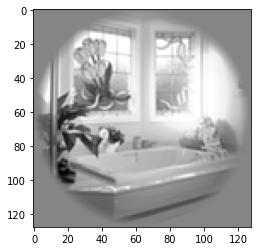

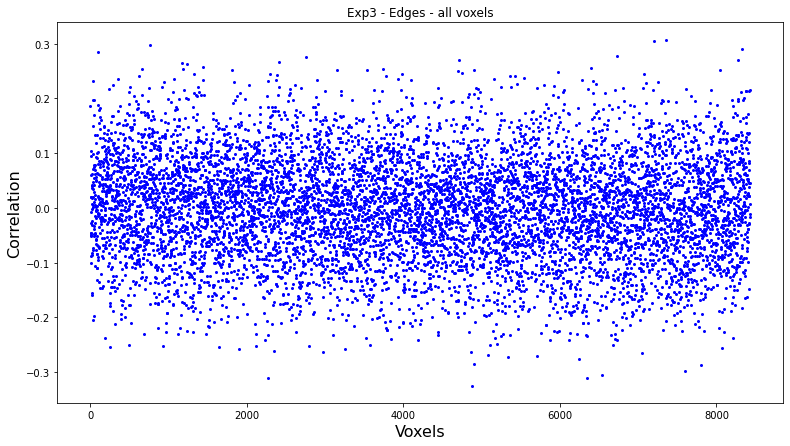

Mean of Correlation: -0.0014925129733036264
Standard Deviation of Correlation:  0.09217641612788662


'\ncorrelation = np.zeros([120,120])\n\nfor i in range(0,120):\n  test_y_pred_pd = pd.Series(test_y_pred[i])\n  for j in range(0,120):\n    test_y_true_pd = pd.Series(test_y_true[j])\n    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)\n\npos = 8\nmaxpos = np.argmax(correlation[pos])\nmax = np.max(correlation[pos])\nprint(maxpos)\nprint(max)\nplt.imshow(dat["stimuli_test"][pos], cmap = "gray")\nplt.title("True Image")\nplt.show()\nplt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")\nplt.title("Predicted Image")\nplt.show()\n'

In [ ]:
train_response = dat["responses"]
test_response = dat["responses_test"]


train_stim = np.zeros([1750, 2*16384])
test_stim = np.zeros([120, 2*16384])

for i in range(0,1750):
  # read image
  img = dat['stimuli'][i]
  #calculating horizontal edges using prewitt kernel
  edges_prewitt_horizontal = prewitt_h(img)
  #calculating vertical edges using prewitt kernel
  edges_prewitt_vertical = prewitt_v(img)
  
  horizontal = edges_prewitt_horizontal.flatten()
  vertical = edges_prewitt_vertical.flatten()
  train_stim[i] = np.concatenate((horizontal,vertical))

for i in range(0,120):
  # read image
  img = dat['stimuli_test'][i]
  #calculating horizontal edges using prewitt kernel
  edges_prewitt_horizontal = prewitt_h(img)
  #calculating vertical edges using prewitt kernel
  edges_prewitt_vertical = prewitt_v(img)
  
  horizontal = edges_prewitt_horizontal.flatten()
  vertical = edges_prewitt_vertical.flatten()
  test_stim[i] = np.concatenate((horizontal,vertical))

# Follow the same regression method as before

rr = Ridge(alpha=0.01)
W = rr.fit(train_stim, train_response)


test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    num_of_correct = num_of_correct + 1
    plt.imshow(dat['stimuli_test'][i], cmap ="gray")
  
print("No. of correct prediction in test set: ", num_of_correct)

import pandas as pd

correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(13,7))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp3 - Edges - all voxels")
plt.show()
print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

'''
correlation = np.zeros([120,120])

for i in range(0,120):
  test_y_pred_pd = pd.Series(test_y_pred[i])
  for j in range(0,120):
    test_y_true_pd = pd.Series(test_y_true[j])
    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)

pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()
'''

PCA + Ridge Regression

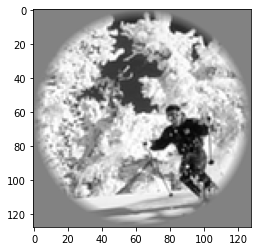

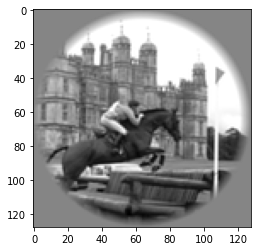

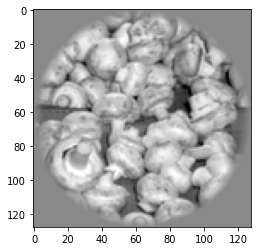

No. of correct prediction in test set:  3


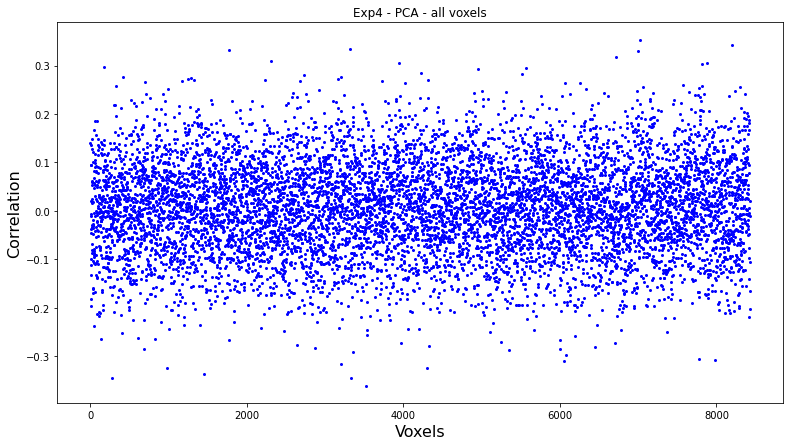

Mean of Correlation: 0.006863847418007873
Standard Deviation of Correlation:  0.09449362810935796


'\ncorrelation = np.zeros([120,120])\n\nfor i in range(0,120):\n  test_y_pred_pd = pd.Series(test_y_pred[i])\n  for j in range(0,120):\n    test_y_true_pd = pd.Series(test_y_true[j])\n    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)\n\npos = 8\nmaxpos = np.argmax(correlation[pos])\nmax = np.max(correlation[pos])\nprint(maxpos)\nprint(max)\nplt.imshow(dat["stimuli_test"][pos], cmap = "gray")\nplt.title("True Image")\nplt.show()\nplt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")\nplt.title("Predicted Image")\nplt.show()\n'

In [ ]:
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

num_of_components = 70
pca = PCA(n_components = num_of_components, whiten = True)
#pca.fit(dat['stimuli'][0])
#print(np.shape(pca.components_.flatten()))
#print(pca.components_)


train_response = dat["responses"]
test_response = dat["responses_test"]


train_stim = np.zeros([1750,128*num_of_components])
test_stim = np.zeros([120,128*num_of_components])

for i in range(0,1750):
  # read image
  img = dat['stimuli'][i]
  # find PCA 
  pca.fit(img)
  train_stim[i] = pca.components_.flatten()

for i in range(0,120):
  # read image
  img = dat['stimuli_test'][i]
  # find PCA 
  pca.fit(img)
  test_stim[i] = pca.components_.flatten()

# Follow the same regression method as before

rr = Ridge(alpha=0.09)
W = rr.fit(train_stim, train_response)


test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    num_of_correct = num_of_correct + 1
    plt.imshow(dat['stimuli_test'][k], cmap ="gray")
    plt.show()
  
print("No. of correct prediction in test set: ", num_of_correct)


import pandas as pd
correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(13,7))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp4 - PCA - all voxels")
plt.show()

print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

'''
correlation = np.zeros([120,120])

for i in range(0,120):
  test_y_pred_pd = pd.Series(test_y_pred[i])
  for j in range(0,120):
    test_y_true_pd = pd.Series(test_y_true[j])
    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)

pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()
'''

In [ ]:
from sklearn.decomposition import FastICA

num_of_components = 2
ica = FastICA(n_components = num_of_components)
# read image
img = dat['stimuli'][0]
# find ICA 
ica.fit(img)
print(np.shape(ica.components_))
x = np.concatenate((ica.components_))
print(np.shape(x))

a= np.array([[1,1],[2,2]])
b= np.concatenate((a))
print(a)
print(b)

(2, 128)
(256,)
[[1 1]
 [2 2]]
[1 1 2 2]


ICA + Ridge Regression

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/_fastica.py:119: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


No. of correct prediction in test set:  0


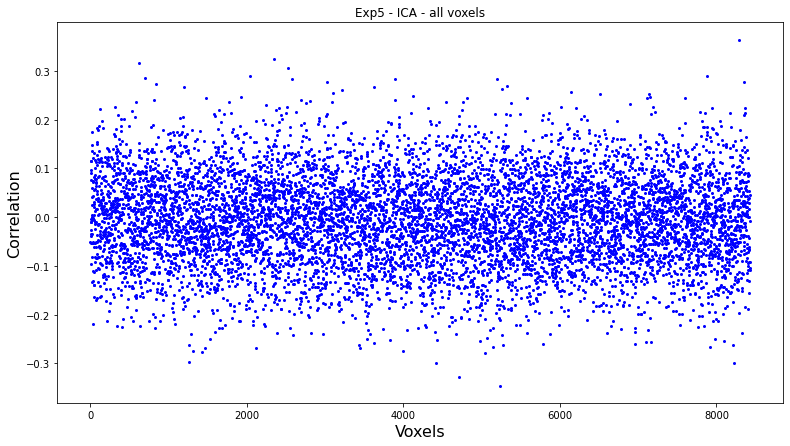

Mean of Correlation: -0.006487865156434895
Standard Deviation of Correlation:  0.08993896222917178


'\ncorrelation = np.zeros([120,120])\n\nfor i in range(0,120):\n  test_y_pred_pd = pd.Series(test_y_pred[i])\n  for j in range(0,120):\n    test_y_true_pd = pd.Series(test_y_true[j])\n    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)\n\npos = 8\nmaxpos = np.argmax(correlation[pos])\nmax = np.max(correlation[pos])\nprint(maxpos)\nprint(max)\nplt.imshow(dat["stimuli_test"][pos], cmap = "gray")\nplt.title("True Image")\nplt.show()\nplt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")\nplt.title("Predicted Image")\nplt.show()\n'

In [ ]:
from sklearn.decomposition import FastICA
from sklearn.linear_model import Ridge

num_of_components = 3
ica = FastICA(n_components = num_of_components, tol=0.1, max_iter=5000)
#pca.fit(dat['stimuli'][0])
#print(np.shape(pca.components_.flatten()))
#print(pca.components_)


train_response = dat["responses"]
test_response = dat["responses_test"]


train_stim = np.zeros([1750,128*num_of_components])
test_stim = np.zeros([120,128*num_of_components])

for i in range(0,1750):
  # read image
  img = dat['stimuli'][i]
  # find ICA 
  ica.fit(img)
  train_stim[i] = np.concatenate((ica.components_))

for i in range(0,120):
  # read image
  img = dat['stimuli_test'][i]
  # find ICA 
  ica.fit(img)
  test_stim[i] = np.concatenate((ica.components_))

# Follow the same regression method as before

rr = Ridge(alpha=0.09)
W = rr.fit(train_stim, train_response)


test_y_pred = W.predict(test_stim)
training_y_pred = W.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    num_of_correct = num_of_correct + 1
    plt.imshow(dat['stimuli_test'][i], cmap ="gray")
    plt.show()
  
print("No. of correct prediction in test set: ", num_of_correct)

import pandas as pd

correlation = np.zeros(8428)

for i in range(0,8428):
  test_y_pred_pd = pd.Series(test_y_pred[:,i])
  test_y_true_pd = pd.Series(test_y_true[:,i])
  correlation[i]=test_y_pred_pd.corr(test_y_true_pd)

voxel = np.arange(8428)
plt.figure(figsize=(13,7))
plt.plot(voxel, correlation, 'bo',markersize=2)
#plt.xlim(0,10)
#plt.ylim()
plt.xlabel("Voxels",fontsize=16)
plt.ylabel("Correlation",fontsize=16)
plt.title("Exp5 - ICA - all voxels")
plt.show()

print("Mean of Correlation:", np.mean(correlation))
print("Standard Deviation of Correlation: ", np.std(correlation))

'''
correlation = np.zeros([120,120])

for i in range(0,120):
  test_y_pred_pd = pd.Series(test_y_pred[i])
  for j in range(0,120):
    test_y_true_pd = pd.Series(test_y_true[j])
    correlation[i][j] = test_y_pred_pd.corr(test_y_true_pd)

pos = 8
maxpos = np.argmax(correlation[pos])
max = np.max(correlation[pos])
print(maxpos)
print(max)
plt.imshow(dat["stimuli_test"][pos], cmap = "gray")
plt.title("True Image")
plt.show()
plt.imshow(dat["stimuli_test"][maxpos], cmap ="gray")
plt.title("Predicted Image")
plt.show()
'''

In [ ]:
from sklearn.linear_model import Lasso

train_response = dat["responses"]
test_response = dat["responses_test"]

#print(train_response.shape)


train_stim = np.zeros([1750,16384])
test_stim = np.zeros([120,16384])



# Obtain flattened train data 
for i in range(0, 1750):
  train_stim[i] = dat["stimuli"][i].flatten()

# Obtain flattened test data
for i in range(0,120):
  test_stim[i] = dat["stimuli_test"][i].flatten()



#W = np.zeros([1750,8428,16384])

L = Lasso(alpha=0.1)

W_lasso = L.fit(train_stim, train_response) 

test_y_pred = W_lasso.predict(test_stim)
training_y_pred = W_lasso.predict(train_stim)

training_y_true = train_response
test_y_true = test_response

print(np.shape(training_y_pred))
print(np.shape(training_y_true))
print(np.shape(test_y_pred))
print(np.shape(test_y_true))

test_num_of_correct = 0
error = np.zeros(120)
for i in range(0,120):
  for j in range(0,120):
    error[j] = np.linalg.norm(test_y_pred[i] - test_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    test_num_of_correct = test_num_of_correct + 1
  
print("No. of correct prediction in test set: ", test_num_of_correct)


training_num_of_correct = 0
error = np.zeros(1750)
for i in range(0,1750):
  for j in range(0,1750):
    error[j] = np.linalg.norm(training_y_pred[i] - training_y_true[j] )
    

  k = np.argmin(error)
  if (k == i):
    training_num_of_correct = training_num_of_correct + 1
  
print("No. of correct prediction in training set: ", training_num_of_correct)



(1750, 8428)
(1750, 8428)
(120, 8428)
(120, 8428)
No. of correct prediction in test set:  1
No. of correct prediction in training set:  1


Obtaining Deep Learning Features

In [ ]:
# Alexnet

import torch
model = torch.hub.load('pytorch/vision:v0.6.0', 'alexnet', pretrained=True)
model.eval()


Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms
#input_image = Image.open(dat["stimuli"][0])
image= dat["stimuli"][0]
input_image = Image.fromarray(image, 'RGB')
input_image.show()
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
input_tensor = preprocess(input_image)
input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

# move the input and model to GPU for speed if available
if torch.cuda.is_available():
    input_batch = input_batch.to('cuda')
    model.to('cuda')

with torch.no_grad():
    output = model(input_batch)
# Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
#print(output[0])
# The output has unnormalized scores. To get probabilities, you can run a softmax on it.
#print(torch.nn.functional.softmax(output[0], dim=0))
